# Problem

We need to repeatedly choose between N possible actions so as to maximize the total reward over a sequence of M choices. Each action results in a random reward drawn from an unknown distribution specific to that action. In this notebook, these are normal distributions with randomly assigned means and variances (but that can be easily changed).

# Parameter setup

In [171]:
actions = 10 # number of actions N (with normally distributed rewards)
steps = 5000 # number of choices made in 1 simulation, M
simulations = 1000 # number of times the simulation is repeated
eps = 0.1 # epsilon for epsilon-greedy approach

# Simulation setup

In [172]:
# Import libraries
import random
import numpy as np

In [173]:
# Function to select action using epsilon-greedy rule
# 3 parameters: actions - number of actions, eps - epsilon, best - action that is currently considered to be "best"
def select_action(actions, eps, best):
    
    if random.random() < eps: # explore
        action = random.randrange(actions-1) # randomly pick one of (actions-1) actions
        if action >= best: # skip the "best" action
            action += 1    
    else: # exploit
        action = best

    return action

In [176]:
# Function to run simulation once
def run_simulation(actions, eps, steps):

    # Initialize parameters
    mean = [random.random() for i in range(actions)] # means rewards for each of the possible actions
    stdev = [random.random() for i in range(actions)] # standard deviations of rewards for each possible action
    actual_best = mean.index(max(mean)) # action with the highest mean reward (for assessing algorithm performance)

    best = random.randrange(actions) # randomly guess "best" action
    # (alternatively, one could try all possible actions once and start with the one that gives highest reward)
    
#    print ("\n Initial best action guess: {:4d}\n".format(best))
    times_tried = [0 for i in range(actions)] # times each action has been tried
    mean_reward = [0. for i in range(actions)] # mean reward approximation for each attempted action
    total_reward = 0. # total reward achieved in simulation
    max_expected_reward = mean[actual_best] * steps # expected reward if best action is always chosen (for assessing performance)
    steps_to_best = 0 # number of steps after which only one "best" action is always chosen
    
    # Run simulation
#    print ("Step".rjust(5), "Action".rjust(15), "Best action".rjust(15), "Reward".rjust(15), "\n")
    for step in range(steps):
    
        action = select_action(actions, eps, best) # select action to take in each step
    
        reward = random.gauss(mean[action], stdev[action]) # get reward from normal distribution for picked action
        total_reward += reward # update total reward
        mean_reward[action] = mean_reward[action] * times_tried[action] + reward # update total reward for picked action
        times_tried[action] += 1 # update number of times the action was taken
        mean_reward[action] /= times_tried[action] # update mean reward for picked action
    
        if mean_reward[best] < max(mean_reward): # if some action has better mean_reward than the assumed "best" action
            best = mean_reward.index(max(mean_reward)) # then assume that action to be the "best"
    
        if best != actual_best: # has the best action been found yet?
            steps_to_best = step + 1

#        print ("{:5d} {:15d} {:15d} {:15.8f}".format(step, action, best, reward))

    return best, actual_best, steps_to_best, total_reward, max_expected_reward, mean, stdev

In [177]:
# Run simulation once
best, actual_best, steps_to_best, total_reward, max_expected_reward,mean, stdev = run_simulation(actions, eps, steps)

print ("Action".rjust(7), "Reward mean".rjust(15), "Reward stdev".rjust(15), "\n")
for action in range(actions):
    print ("{:7d} {:15.8f} {:15.8f}".format(action, mean[action], stdev[action]))

print ("\n Best action predicted after {:5d} steps: {:4d}".format(steps, best))
print (" Actual best action: {:4d}".format(actual_best))
print (" Steps to settle on best action: {:4d}".format(steps_to_best))
print (" Percentage of maximum expected reward achieved: {:15.8f}".format(total_reward/max_expected_reward*100))

 Action     Reward mean    Reward stdev 

      0      0.60054435      0.45030304
      1      0.91215228      0.23817044
      2      0.42005822      0.42206299
      3      0.95828801      0.00756597
      4      0.16272571      0.33375642
      5      0.64592517      0.57148478
      6      0.08268126      0.95711055
      7      0.40775017      0.17653437
      8      0.29248770      0.90323034
      9      0.11857278      0.60469070

 Best action predicted after  5000 steps:    3
 Actual best action:    3
 Steps to settle on best action: 1404
 Percentage of maximum expected reward achieved:     94.17157320


In [215]:
# Function to run simulation repeatedly
def run_repeatedly(actions, eps, steps, simulations):

    corrects = [] # List of outcomes for individual simulations: best action predicted? (True/False)
    steps_to_predict = [] # Steps it took to converge on best action (== steps if hadn't converged to best action)
    fracs_max_reward = [] # Fractions of maximum expected reward achieved
    
    correct = 0. # fraction of simulations that converged on best action
    for simulation in range(simulations):
        best, actual_best, steps_to_best, total_reward, max_expected_reward, _, _ = run_simulation(actions, eps, steps)
        if best == actual_best: # have we predicted the actual "best" action correctly?
            correct += 1
            corrects.append(True)
        else:
            corrects.append(False)
        steps_to_predict.append(steps_to_best) # how many steps did we take before we started choosing the "best" action consistently for each simulation?
        fracs_max_reward.append(total_reward/max_expected_reward) # what fraction of the maximum expected reward did we achieve in each simulation?
    correct /= simulations # percentage of simulations that correctly chose the best action
    
    return correct, corrects, steps_to_predict, fracs_max_reward

In [182]:
# Run simulation repeatedly (may take some time)
correct, corrects, steps_to_predict, fracs_max_reward = run_repeatedly(actions, eps, steps, simulations)

steps_successful = [] # numbers of steps to converge on correct answer (for successful runs)
print ("Correct?".rjust(10), "Steps to predict".rjust(18), "% max expected reward".rjust(23), "\n")
for simulation in range(simulations):
    print ("{:10s} {:18d} {:23.8f}".format(str(corrects[simulation]).rjust(10), steps_to_predict[simulation], fracs_max_reward[simulation]*100))
    if corrects[simulation] == True:
        steps_successful.append(steps_to_predict[simulation])

  Correct?   Steps to predict   % max expected reward 

      True                895             95.40607981
     False               5000             91.62513634
      True                 32             92.44176731
      True                955             93.75065513
      True                488             92.91987265
     False               5000             90.17937585
      True                135             93.56876048
      True               4573             94.39688258
     False               5000             79.40467843
      True                378             94.72282341
      True                146             95.10539601
     False               5000             91.40752620
      True                 33             95.34653798
      True               1939             95.17725856
      True                332             96.51433039
     False               5000             85.82477696
      True                119             94.08356651
      True               2

In [187]:
# Analyze results

print ("\nPercent correct: {:15.8f}".format(correct*100))
steps_successful = np.asarray(steps_successful)
print ("Mean number of steps to converge on correct answer (if converged): {:15.8f}".format(np.mean(steps_successful)))
print ("Standard deviation for the number of steps to converge on correct answer: {:15.8f}".format(np.std(steps_successful)))
fracs_max_reward = np.asarray(fracs_max_reward)
print ("Mean percentage of maximum expected reward achieved: {:15.8f}".format(np.mean(fracs_max_reward)*100))
print ("Standard deviation for percentage of maximum expected reward achieved: {:15.8f}".format(np.std(fracs_max_reward)*100))


Percent correct:     84.60000000
Mean number of steps to converge on correct answer (if converged):   1302.16784870
Standard deviation for the number of steps to converge on correct answer:   1412.68716669
Mean percentage of maximum expected reward achieved:     93.37049053
Standard deviation for percentage of maximum expected reward achieved:      2.66839112


# Varying epsilon

In [199]:
# Vary epsilon
n_epsilons = 101 # number of epsilon values to try
epsilons = [i/(n_epsilons-1) for i in range(n_epsilons)] # list of epsilon values to try
pct_correct = np.zeros(n_epsilons) # percent correct for each epsilon value
steps_to_best = np.zeros(n_epsilons) # mean number of steps to find best action for each epsilon
pct_max_reward = np.zeros(n_epsilons) # percent max expected reward for each epsilon value

print ("Epsilon".rjust(10), "% correct".rjust(15), "Mean steps to predict".rjust(23), "% max expected reward".rjust(23), "\n")
for i in range(n_epsilons):
    eps = epsilons[i]
    
    correct, corrects, steps_to_predict, fracs_max_reward = run_repeatedly(actions, eps, steps, simulations)
    corrects = np.asarray(corrects)
    steps_to_predict = np.asarray(steps_to_predict)
    pct_correct[i] = np.mean(corrects)*100
    steps_to_best[i] = np.mean(corrects*steps_to_predict)
    pct_max_reward[i] = np.mean(fracs_max_reward)*100

    print ("{:10.2f}{:15.8f}{:23.8f}{:23.8f}".format(eps, pct_correct[i], steps_to_best[i], pct_max_reward[i]))

   Epsilon       % correct   Mean steps to predict   % max expected reward 

      0.00    14.00000000             0.27600000            65.51510466
      0.01    68.80000000          1672.91300000            92.68553679
      0.02    74.10000000          1541.18300000            94.76656974
      0.03    74.30000000          1427.57000000            94.95830530
      0.04    80.60000000          1381.13200000            95.25554436
      0.05    77.50000000          1275.15300000            94.88383836
      0.06    79.10000000          1212.01100000            94.73282575
      0.07    81.80000000          1243.08300000            94.48899648
      0.08    80.80000000          1208.11300000            94.25263345
      0.09    84.30000000          1158.91100000            93.77529497
      0.10    81.30000000          1026.60500000            93.45360813
      0.11    84.30000000          1078.99700000            93.00031725
      0.12    86.60000000          1066.84700000           

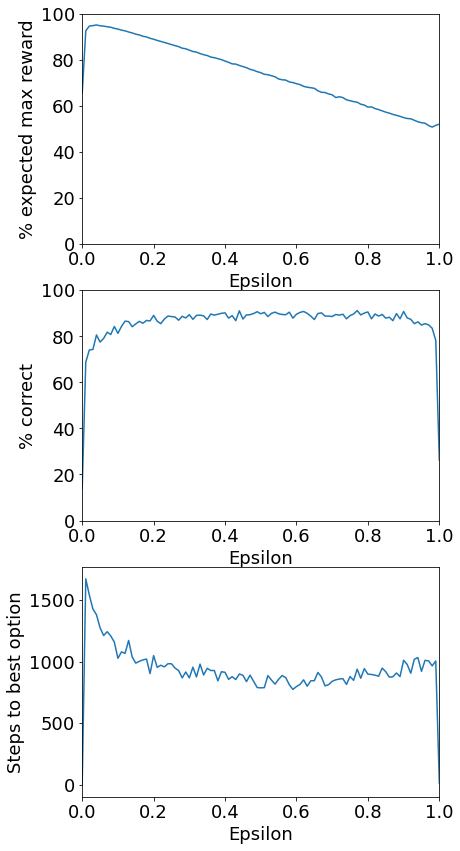

In [216]:
# Plot results
import matplotlib.pyplot as plt
from matplotlib import rc

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
rc('font', **font)

plt.figure(1, figsize=(6.4, 14.4))
plt.subplot(311)
plt.xlim(0,1)
plt.ylim(0,100)
plt.xlabel("Epsilon")
plt.ylabel("% expected max reward")
plt.plot (epsilons, pct_max_reward)
plt.subplot(312)
plt.xlim(0,1)
plt.ylim(0,100)
plt.xlabel("Epsilon")
plt.ylabel("% correct")
plt.plot (epsilons, pct_correct)
plt.subplot(313)
plt.xlim(0,1)
plt.ylim(steps_to_best.min()-100, steps_to_best.max()+100)
plt.xlabel("Epsilon")
plt.ylabel("Steps to best option")
plt.plot (epsilons, steps_to_best)